In [1]:
import pandas as pd

In [2]:

df = pd.read_csv("time_series_covid19_confirmed_global.csv")
df.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,2/28/23,3/1/23,3/2/23,3/3/23,3/4/23,3/5/23,3/6/23,3/7/23,3/8/23,3/9/23
0,NaN,Afghanistan,33.93911,67.709953,0,0,0,0,0,0,...,209322,209340,209358,209362,209369,209390,209406,209436,209451,209451
1,NaN,Albania,41.15330,20.168300,0,0,0,0,0,0,...,334391,334408,334408,334427,334427,334427,334427,334427,334443,334457
2,NaN,Algeria,28.03390,1.659600,0,0,0,0,0,0,...,271441,271448,271463,271469,271469,271477,271477,271490,271494,271496
3,NaN,Andorra,42.50630,1.521800,0,0,0,0,0,0,...,47866,47875,47875,47875,47875,47875,47875,47875,47890,47890
4,NaN,Angola,-11.20270,17.873900,0,0,0,0,0,0,...,105255,105277,105277,105277,105277,105277,105277,105277,105288,105288


In [3]:
df["Country/Region"].unique()

array(['Afghanistan', 'Albania', 'Algeria', 'Andorra', 'Angola',
       'Antarctica', 'Antigua and Barbuda', 'Argentina', 'Armenia',
       'Australia', 'Austria', 'Azerbaijan', 'Bahamas', 'Bahrain',
       'Bangladesh', 'Barbados', 'Belarus', 'Belgium', 'Belize', 'Benin',
       'Bhutan', 'Bolivia', 'Bosnia and Herzegovina', 'Botswana',
       'Brazil', 'Brunei', 'Bulgaria', 'Burkina Faso', 'Burma', 'Burundi',
       'Cabo Verde', 'Cambodia', 'Cameroon', 'Canada',
       'Central African Republic', 'Chad', 'Chile', 'China', 'Colombia',
       'Comoros', 'Congo (Brazzaville)', 'Congo (Kinshasa)', 'Costa Rica',
       "Cote d'Ivoire", 'Croatia', 'Cuba', 'Cyprus', 'Czechia', 'Denmark',
       'Diamond Princess', 'Djibouti', 'Dominica', 'Dominican Republic',
       'Ecuador', 'Egypt', 'El Salvador', 'Equatorial Guinea', 'Eritrea',
       'Estonia', 'Eswatini', 'Ethiopia', 'Fiji', 'Finland', 'France',
       'Gabon', 'Gambia', 'Georgia', 'Germany', 'Ghana', 'Greece',
       'Grenada', 'Gua

In [4]:
df = df[df['Country/Region'] == "China"]
df_confirmed_country = pd.DataFrame(df[df.columns[4:]].sum(),columns=["confirmed"])
df_confirmed_country.index = pd.to_datetime(df_confirmed_country.index,format='%m/%d/%y')

In [5]:
df_confirmed_country

,confirmed
2020-01-22,548
2020-01-23,643
2020-01-24,920
2020-01-25,1406
2020-01-26,2075
...,...
2023-03-05,4903524
2023-03-06,4903524
2023-03-07,4903524
2023-03-08,4903524


<Axes: title={'center': 'COVID 19 confirmed cases'}>

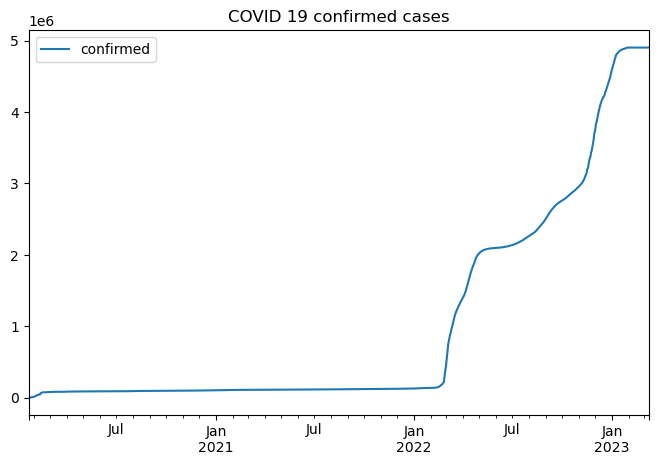

In [6]:
df_confirmed_country.plot(figsize=(8,5), title="COVID 19 confirmed cases")


In [7]:
print("Total days in dataset", len(df_confirmed_country))

Total days in dataset 1143


In [8]:
x = len(df_confirmed_country) - 14
train = df_confirmed_country.iloc[:x]
test = df_confirmed_country.iloc[x:]

In [9]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(train)

MinMaxScaler()

In [10]:
train_scaled = scaler.transform(train)
test_scaled = scaler.transform(test)

In [11]:
from keras.preprocessing.sequence import TimeseriesGenerator

In [12]:
seq_length = 7
n_features =1

train_generator = TimeseriesGenerator(train_scaled,train_scaled, length = seq_length, batch_size = n_features)
print("Total number of samples in original data", len(train))
print("Total number of samples in time series generated data", len(train_generator))

Total number of samples in original data 1129
Total number of samples in time series generated data 1122


In [13]:
x,y = train_generator[10]
print(x.shape,y.shape)

(1, 7, 1) (1, 1)


In [14]:
test_generator = TimeseriesGenerator(test_scaled,test_scaled, length = seq_length, batch_size = n_features)
print("Total number of samples in original test data", len(test))
print("Total number of samples in time series generated test data", len(test_generator))

Total number of samples in original test data 14
Total number of samples in time series generated test data 7


In [15]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Activation, Dropout

In [16]:
model = Sequential()
model.add(LSTM(150, activation='relu', return_sequences = True, input_shape=(seq_length, n_features)))
model.add(LSTM(64, activation='relu'))
model.add(Dense(64))
model.add(Dense(1))

model.compile(optimizer='adam', loss = "mean_squared_error")

model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 7, 150)            91200     
                                                                 
 lstm_1 (LSTM)               (None, 64)                55040     
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 150,465
Trainable params: 150,465
Non-trainable params: 0
_________________________________________________________________


In [17]:
history = model.fit_generator(train_generator, validation_data = test_generator, epochs = 50, steps_per_epoch =10)


Epoch 1/50


C:\Users\MS\AppData\Local\Temp\ipykernel_10172\2282373333.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_generator, validation_data = test_generator, epochs = 50, steps_per_epoch =10)


10/10 [==============================] - 10s 176ms/step - loss: 0.1279 - val_loss: 0.6266
Epoch 2/50
10/10 [==============================] - 0s 33ms/step - loss: 0.0662 - val_loss: 0.3716
Epoch 3/50
10/10 [==============================] - 0s 28ms/step - loss: 0.0310 - val_loss: 0.0240
Epoch 4/50
10/10 [==============================] - 0s 27ms/step - loss: 0.0277 - val_loss: 0.0060
Epoch 5/50
10/10 [==============================] - 0s 31ms/step - loss: 0.0024 - val_loss: 0.0601
Epoch 6/50
10/10 [==============================] - 0s 26ms/step - loss: 0.0102 - val_loss: 0.0560
Epoch 7/50
10/10 [==============================] - 0s 38ms/step - loss: 0.0028 - val_loss: 0.0191
Epoch 8/50
10/10 [==============================] - 0s 35ms/step - loss: 0.0046 - val_loss: 4.9604e-04
Epoch 9/50
10/10 [==============================] - 0s 31ms/step - loss: 0.0051 - val_loss: 0.0089
Epoch 10/50
10/10 [==============================] - 0s 30ms/step - loss: 8.4385e-04 - val_loss: 2.0397e-04
Epoch 

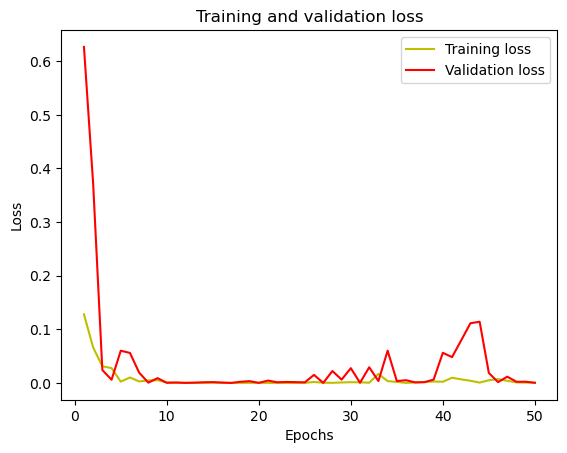

In [18]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [19]:
import numpy as np

predictions = []

current_batch = train_scaled[-seq_length:] #Final data points in train 
current_batch = current_batch.reshape(1, seq_length, n_features) #Reshape

future = 7

for i in range(len(test)+ future):
    curr_pred = model.predict(current_batch)[0]
    predictions.append(curr_pred)
    current_batch = np.append(current_batch[:,1:,:], [[curr_pred]], axis=1)


rescaled_output = scaler.inverse_transform(predictions)

1/1 [==============================] - 0s 57ms/step


In [20]:
time_series_array = test.index  #Get dates for test data

#Add new dates for the forecast period
for k in range(0, future):
    time_series_array = time_series_array.append(time_series_array[-1:] + pd.DateOffset(1))

In [21]:
df_forecast = pd.DataFrame(columns=["Actual", "Predicted"], index = time_series_array)

<Axes: title={'center': 'Predictions for next 7 days'}>

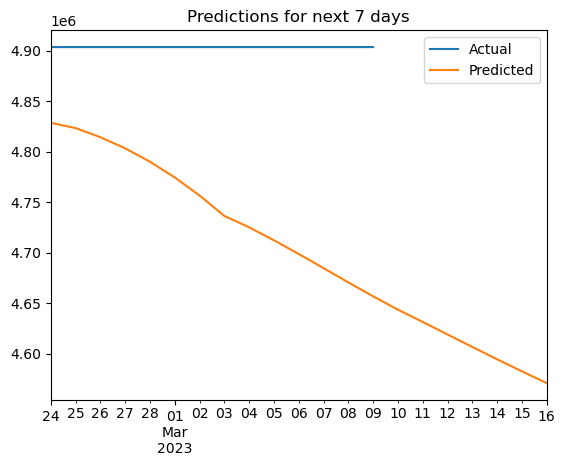

In [22]:
df_forecast.loc[:,"Predicted"] = rescaled_output[:,0]
df_forecast.loc[:,"Actual"] = test["confirmed"]

#Plot
df_forecast.plot(title="Predictions for next 7 days")

In [23]:
df_forecast['Actual'].tail(50)

2023-02-24    4903523.0
2023-02-25    4903524.0
2023-02-26    4903524.0
2023-02-27    4903524.0
2023-02-28    4903524.0
2023-03-01    4903524.0
2023-03-02    4903524.0
2023-03-03    4903524.0
2023-03-04    4903524.0
2023-03-05    4903524.0
2023-03-06    4903524.0
2023-03-07    4903524.0
2023-03-08    4903524.0
2023-03-09    4903524.0
2023-03-10          NaN
2023-03-11          NaN
2023-03-12          NaN
2023-03-13          NaN
2023-03-14          NaN
2023-03-15          NaN
2023-03-16          NaN
Name: Actual, dtype: object